<a href="https://colab.research.google.com/github/LINNETWAHOME02/RFM_Analysis_project/blob/main/RFM_Analysis_Practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generating sales CSV

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# Generate synthetic data
np.random.seed(42)  # For reproducibility
num_records = 1000

# Generate OrderID (unique sequential IDs starting at 1001)
order_ids = list(range(1001, 1001 + num_records))

# Dates: Jan 2023 to June 2023
dates = pd.date_range(start='2023-01-01', end='2023-06-30', freq='D')
order_dates = np.random.choice(dates, num_records)

# Products and pricing logic
products = ['Product_A', 'Product_B', 'Product_C', 'Product_D', 'Product_E']
product_list = np.random.choice(products, num_records, p=[0.3, 0.25, 0.2, 0.15, 0.1])  # Weighted probabilities

# Generate quantities and prices
quantities = np.random.randint(1, 15, num_records)  # Quantity between 1-14
unit_prices = np.round(np.random.uniform(10, 50, num_records), 2)  # Prices between $10-$50

# Create DataFrame with all columns
data = pd.DataFrame({
    'OrderID': order_ids,
    'OrderDate': order_dates,
    'Product': product_list,
    'Quantity': quantities,
    'UnitPrice': unit_prices
})

# Save to CSV
data.to_csv('sales_data.csv', index=False)

### Loading the dataset

In [ ]:
df = pd.read_csv('/content/sales_data.csv')
df.head(3)

,OrderID,OrderDate,Product,Quantity,UnitPrice
0,1001,2023-04-13,Product_C,3,28.79
1,1002,2023-06-29,Product_E,9,28.02
2,1003,2023-04-03,Product_A,3,28.92


### Understanding the data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OrderID    1000 non-null   int64  
 1   OrderDate  1000 non-null   object 
 2   Product    1000 non-null   object 
 3   Quantity   1000 non-null   int64  
 4   UnitPrice  1000 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB


In [ ]:
# Convert the OrderDate column to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

In [ ]:
df.columns

Index(['OrderID', 'OrderDate', 'Product', 'Quantity', 'UnitPrice'], dtype='object')

In [ ]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
OrderID,1000.0,1500.5,1001.0,1250.75,1500.5,1750.25,2000.0,288.819436
OrderDate,1000,2023-04-01 12:40:19.200000,2023-01-01 00:00:00,2023-02-16 00:00:00,2023-04-04 00:00:00,2023-05-16 00:00:00,2023-06-30 00:00:00,NaN
Quantity,1000.0,7.461,1.0,4.0,7.0,11.0,14.0,3.964366
UnitPrice,1000.0,30.58112,10.02,20.86,31.115,40.4825,49.99,11.402576


In [ ]:
df.duplicated().sum()

np.int64(0)

*   No Null values
*   No duplicate records

Therefore we can move on to the tasks



#### 1. Add a **CustomerID** column (assign random customer IDs for simulation)

In [ ]:
import random
df['CustomerID'] = np.random.randint(0,1000, size=len(df))

In [ ]:
df.head()

,OrderID,OrderDate,Product,Quantity,UnitPrice,CustomerID
0,1001,2023-04-13,Product_C,3,28.79,941
1,1002,2023-06-29,Product_E,9,28.02,541
2,1003,2023-04-03,Product_A,3,28.92,56
3,1004,2023-01-15,Product_A,5,34.90,231
4,1005,2023-04-17,Product_C,9,28.79,657


#### RFM Calculation:

*   **Recency**: Days since the last purchase (reference date: max(OrderDate) + 1 day).

*   **Frequency**: Total number of purchases per customer.

*   **Monetary**: Total revenue generated per customer.

In [ ]:
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']

print('Extracting the columns needed for RFM...')
temp = ['CustomerID', 'OrderID', 'OrderDate', 'TotalRevenue']
RFM_data = df[temp]
RFM_data.shape

Extracting the columns needed for RFM...


(1000, 4)

In [ ]:
RFM_data.columns

Index(['CustomerID', 'OrderID', 'OrderDate', 'TotalRevenue'], dtype='object')

In [ ]:
from datetime import datetime, timedelta
import pytz

# RFM_data['OrderDate'] = pd.to_datetime(RFM_data['OrderDate'])

# Defining the reference date variable to the last date in the orderdate column
reference_date = RFM_data['OrderDate'].max() + timedelta(days = 1)

In [ ]:
# Creating an RFM table

RFM_table = RFM_data.groupby('CustomerID').agg(
    {
        # Recency - difference btwn the refernce date and the most recent date the customer made an order, returns the number of days
        'OrderDate': lambda x: (reference_date - x.max()).days,

        # Frequency - essentially count the number of orders made by the customer
        'OrderID': lambda x: len(x.unique()),

        # Monetary - sum of total spent by each customer
        'TotalRevenue': lambda x: x.sum()
    }
)

In [ ]:
RFM_table['OrderDate'] = RFM_table['OrderDate'].astype(int)

RFM_table.rename(columns={'OrderDate': 'recency',
                         'OrderID': 'frequency',
                         'TotalRevenue': 'monetary_value'}, inplace=True)
RFM_table.head()

,recency,frequency,monetary_value
CustomerID,,,
0,179,1,52.30
1,97,1,211.75
2,51,1,517.72
4,71,2,215.20
5,48,2,225.62


### Segmentation by assigning scores:

*   Split customers into 4 quantile-based segments (e.g., "High-Value", "Medium-Value", etc.) for each RFM metric.

*   Create an overall RFM score (e.g., RFM_Score = R_rank + F_rank + M_rank)

In [ ]:
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,34.0,1.0,159.85
0.50,66.0,1.0,286.02
0.75,120.0,2.0,484.33


In [ ]:
# Assigning a scoring based on the quantiles

# x => val_to_be_scored; that is; the recency, frequency, and monetary_value column values
# p => col_name; that is; the recency, frequency, and monetary_value column
# d => dataframe_containing_quantiles; the quantiles table

def rfm_score(x, p, d):
  # For recency, the least value should be scored highly, since the lower the value the more recent the purchase
  if p == 'recency':
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
  # For frequency and monetary_value, the largest value should be scored highly, since the higher the value the more purchases were made
  else:
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

In [ ]:
# Applying the scoring function
RFM_table['R_rank'] = RFM_table['recency'].apply(rfm_score, args=('recency', quantiles,))

RFM_table['F_rank'] = RFM_table['frequency'].apply(rfm_score, args=('frequency', quantiles,))

RFM_table['M_rank'] = RFM_table['monetary_value'].apply(rfm_score, args=('monetary_value', quantiles,))

In [ ]:
RFM_table.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank
CustomerID,,,,,,
0,179,1,52.30,1,1,1
1,97,1,211.75,2,1,2
2,51,1,517.72,3,1,4
4,71,2,215.20,2,3,2
5,48,2,225.62,3,3,2


In [ ]:
RFM_table.tail()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank
CustomerID,,,,,,
991,61,3,417.98,3,4,3
992,35,1,58.86,3,1,1
993,155,1,96.95,1,1,1
997,161,1,213.57,1,1,2
998,10,1,371.70,4,1,3


#### Combine Scores into RFM_Score:
*   Sum ***R_rank***, ***F_rank***, and ***M_rank*** to get a total score (e.g., RFM_Score = R + F + M).

In [ ]:
# Consolidated score segment => string representation of each RFM score for each customer
RFM_table['RFM_segment'] = RFM_table['R_rank'].astype(str) + RFM_table['F_rank'].astype(str) + RFM_table['M_rank'].astype(str)

# Calculating total score => highest = 12 (4 + 4 + 4), lowest = 3 (1 + 1 + 1)
RFM_table['RFM_score'] = RFM_table[['R_rank', 'F_rank', 'M_rank']].sum(axis=1)

In [ ]:
RFM_table.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,RFM_segment,RFM_score
CustomerID,,,,,,,,
0,179,1,52.30,1,1,1,111,3
1,97,1,211.75,2,1,2,212,5
2,51,1,517.72,3,1,4,314,8
4,71,2,215.20,2,3,2,232,7
5,48,2,225.62,3,3,2,332,8


#### Define Segments
*   Example Segmentation Logic:

    *   ***High-Value***: Top 20% (RFM_Score ≥ 10).
    *   ***Medium-Value***: Middle 40-60%.
    *   ***Low-Value***: Bottom 20% (RFM_Score ≤ 5).

In [ ]:
def RFM_segmented(score):
  if score >= 10:
    return 'High-Value'
  elif score <= 5:
    return 'Low-Value'
  else:
    return 'Medium-Value'

In [ ]:
RFM_table['segment'] = RFM_table['RFM_score'].apply(RFM_segmented)

In [ ]:
RFM_table.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,RFM_segment,RFM_score,segment
CustomerID,,,,,,,,,
0,179,1,52.30,1,1,1,111,3,Low-Value
1,97,1,211.75,2,1,2,212,5,Low-Value
2,51,1,517.72,3,1,4,314,8,Medium-Value
4,71,2,215.20,2,3,2,232,7,Medium-Value
5,48,2,225.62,3,3,2,332,8,Medium-Value


In [ ]:
RFM_table.tail()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,RFM_segment,RFM_score,segment
CustomerID,,,,,,,,,
991,61,3,417.98,3,4,3,343,10,High-Value
992,35,1,58.86,3,1,1,311,5,Low-Value
993,155,1,96.95,1,1,1,111,3,Low-Value
997,161,1,213.57,1,1,2,112,4,Low-Value
998,10,1,371.70,4,1,3,413,8,Medium-Value


#### Visualize Results

*   ***Heatmap***: Show correlation between R, F, and M.
*   ***Bar Plot***: Display the count of customers in each segment.

In [ ]:
# First creating a count variable to count the total number of customers in each segment

count_per_segment = RFM_table['segment'].value_counts().reset_index()
count_per_segment

,segment,count
0,Medium-Value,285
1,Low-Value,222
2,High-Value,130


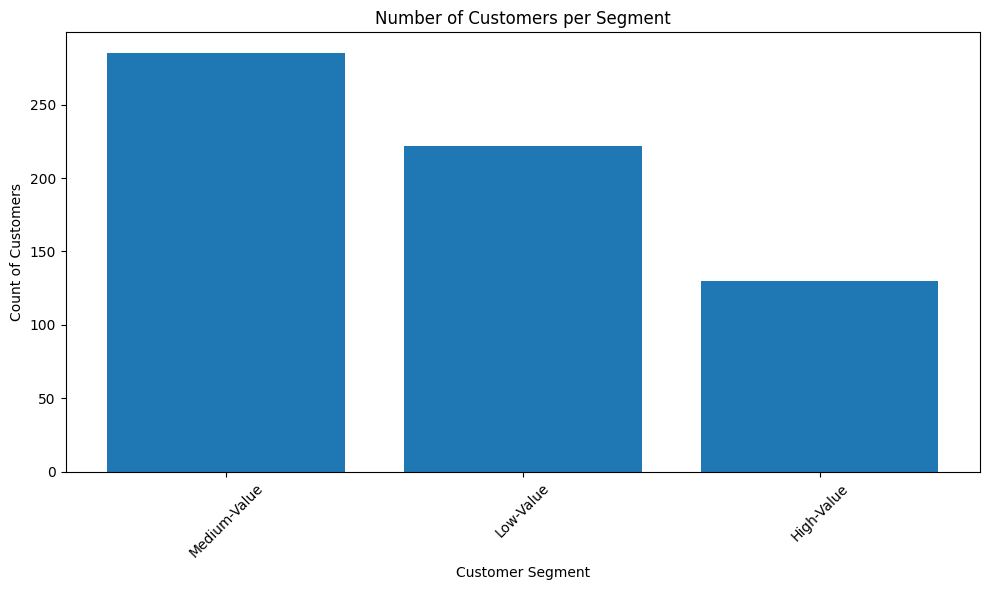

In [ ]:
import matplotlib.pyplot as plt

# Rename columns for clarity
count_per_segment.columns = ['segment', 'count']

# Bar plot using the aggregated values
plt.figure(figsize=(10,6))
plt.bar(count_per_segment['segment'], count_per_segment['count'])
plt.xlabel('Customer Segment')
plt.ylabel('Count of Customers')
plt.title('Number of Customers per Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

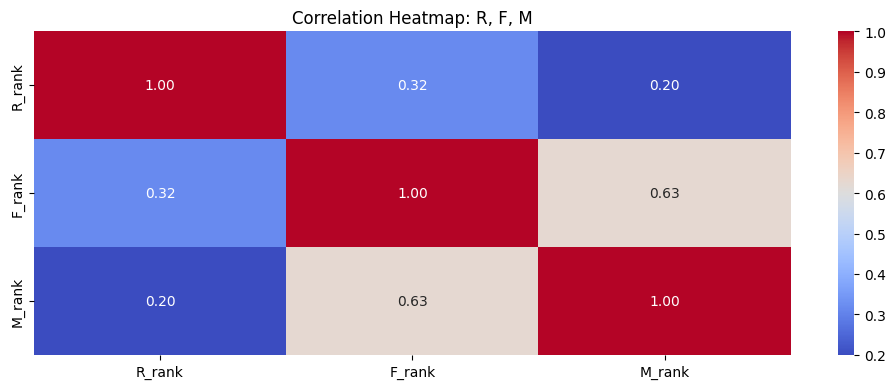

In [ ]:
import seaborn as sns

# 1. Select only R, F, M columns
rfm = RFM_table[['R_rank', 'F_rank', 'M_rank']]

# 2. Compute the correlation matrix
correlation_matrix = rfm.corr()

# 3. Create the heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: R, F, M')
plt.tight_layout()
plt.show()